In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import pandas as pd

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')

In [2]:
fn = 'howell.csv'

In [3]:
data = pd.read_csv(fn, index_col=0)

In [4]:
data.head()

,height,weight,age,male
1,151.765,47.825606,63.0,1
2,139.700,36.485807,63.0,0
3,136.525,31.864838,65.0,0
4,156.845,53.041915,41.0,1
5,145.415,41.276872,51.0,0


In [5]:
# Get the zeroed weights
weight_s = (data.weight - data.weight.mean()) / data.weight.std()
data['weight_s'] = weight_s
data['weight_s2'] = weight_s**2
data['weight_s3'] = weight_s**3

In [6]:
with pm.Model() as model:
    a = pm.Normal('a', 178, 20)
    b1 = pm.Lognormal('b1', 0, 1)
    b2 = pm.Normal('b2', 0, 1)
    b3 = pm.Normal('b3', 0, 1)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    mu = pm.Deterministic('mu', a + b1*data.weight_s + b2*data.weight_s2 + b3*data.weight_s3)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=data.height)
    
    weight_s = tt.as_tensor_variable(data.weight)
    weight = pm.Deterministic('weight', weight_s)
    
    trace = pm.sample(2000, tune=1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b3, b2, b1, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:09<00:00, 624.77draws/s]


In [7]:
# Summarize our fit
pm.summary(trace).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,146.393575,0.308426,0.006248,145.764412,146.985923,2635.203134,0.999796
b2,-6.207631,0.252309,0.004875,-6.709296,-5.738867,2627.167474,0.999753
b3,3.577199,0.220558,0.004720,3.136630,3.999216,2302.330585,1.000667
b1,15.228152,0.463077,0.010120,14.397689,16.187439,2431.105941,1.000488
sigma,4.759537,0.135448,0.002016,4.502686,5.029437,3443.891398,0.999808


In [8]:
# pm.traceplot(trace);

In [9]:
# Get samples from posterior
with model:
    samples = pm.sample_posterior_predictive(trace, 
                                             samples=1000, 
                                             vars=[height, weight, a, b1, b2, b3, sigma]
                                            )

100%|██████████| 1000/1000 [00:00<00:00, 1380.29it/s]


In [10]:
weights_to_predict = [45, 40, 65, 31, 53]

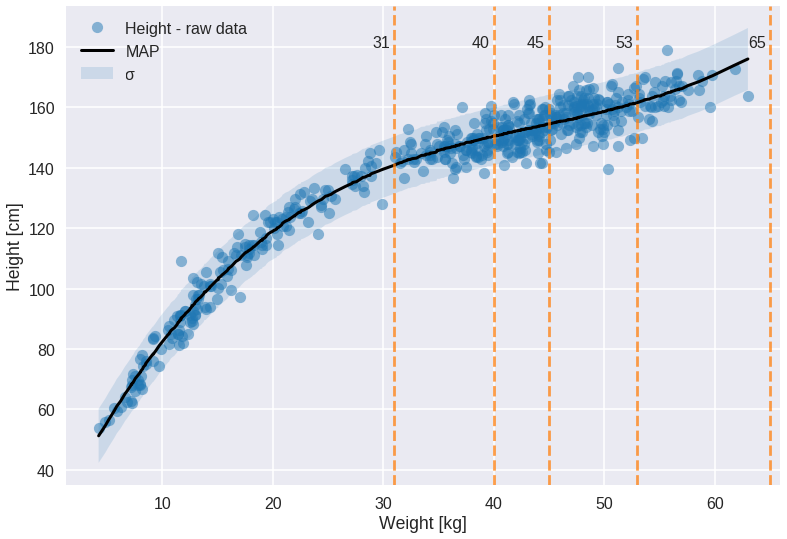

In [11]:
with plt.style.context('seaborn-poster'):

    fig, ax = plt.subplots(1)

    # Raw data
    ax.plot(data.weight, data.height, ls='', marker='o', alpha=0.5, label='Height - raw data')

    # MAP and std
    x_range = sorted(samples['weight'].mean(0))
    mu = np.array(sorted(samples['height'].mean(0)))
    sd = np.array(sorted(samples['height'].std(0)))

    ax.plot(x_range, mu, lw=3, label='MAP', c='k');
    ax.fill_between(x_range, mu - 2*sd, mu + 2*sd, alpha=0.15, label='σ')

    for w in weights_to_predict:
        ax.axvline(w, ls='--', color='C1', alpha=0.75)
        ax.annotate(w, (w-2, 180), fontsize=16)

    ax.set_xlabel('Weight [kg]')
    ax.set_ylabel('Height [cm]')
    ax.legend();

In [16]:
def predict(weight, do_plot=False):
    # Corrected weight
    x_i = (weight - data.weight.mean()) / data.weight.std()

    # Use samples to find predicted means
    mu_pred = samples['a'] + (samples['b1'] * x_i) + (samples['b2'] * x_i**2) + (samples['b3'] * x_i**3)

    # Use our mu and sigma values to pull from normal distribution
    mus = pm.Normal.dist(mu_pred, samples['sigma']).random(1000)
    mus_mean = mus.mean()
    
    # Get our sigma mean: NOTE: should be doing something better?
    # See error bars below compared to 
    sigma = mus.std()

    if do_plot:
        fig, ax = plt.subplots(1)
        ax.hist(mus)
        ax.axvline(mus_mean, color='r', ls='--', lw=3, label=f'σ={mus_mean:.02f}')
        ax.set_title(f'Weight: {weight} kg Predicted Height: {mus_mean:.02f} ± {sigma:.02f} cm')
        ax.legend();
    
    return (mus_mean, sigma)

## Predicted Heights

In [17]:
# Get the predicted heights and sigma for each weight.
h0 = pd.DataFrame([(w, *predict(w)) for w in weights_to_predict], 
                  columns=['weight', 'height', 'sigma']).set_index(['weight']).sort_index()

h0['low'] = h0.height - h0.sigma
h0['high'] = h0.height + h0.sigma

            height     sigma         low        high
weight                                              
31      140.854658  4.883675  135.970983  145.738334
40      150.639452  4.828374  145.811078  155.467826
45      154.739398  4.726289  150.013109  159.465687
53      161.498624  4.556382  156.942242  166.055006
65      180.512009  5.310579  175.201429  185.822588


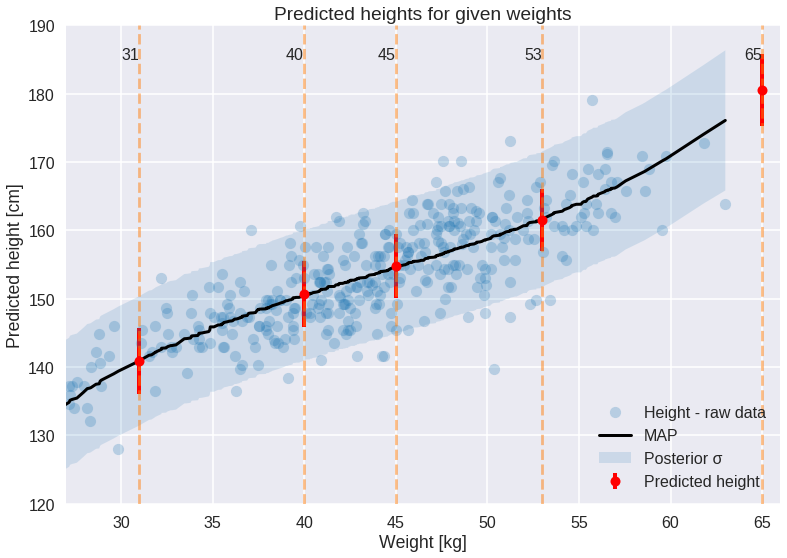

In [18]:
with plt.style.context('seaborn-poster'):
    fig, ax = plt.subplots(1)

    # Raw data
    ax.plot(data.weight, data.height, ls='', marker='o', alpha=0.25, label='Height - raw data')

    # MAP and std
    x_range = sorted(samples['weight'].mean(0))
    mu = np.array(sorted(samples['height'].mean(0)))
    sd = np.array(sorted(samples['height'].std(0)))

    ax.plot(x_range, mu, lw=3, label='MAP', c='k');
    ax.fill_between(x_range, mu - 2*sd, mu + 2*sd, alpha=0.15, label='Posterior σ')

    for w in weights_to_predict:
        ax.axvline(w, ls='--', color='C1', alpha=0.5)
        ax.annotate(w, (w-1, 185), fontsize=16)

    ax.errorbar(h0.index, h0.height, yerr=h0.sigma, 
                ls='', lw=4, 
                marker='o', markersize=10, color='r',
                label='Predicted height')

    ax.set_title('Predicted heights for given weights')
    ax.set_ylabel('Predicted height [cm]')
    ax.set_xlabel('Weight [kg]')    
    ax.legend(loc=4);
    ax.set_xlim([27, 66])
    ax.set_ylim([120, 190]);
    print(h0)